<a href="https://colab.research.google.com/github/chiayewken/keras-efficientnets/blob/master/Keras_EfficientNet_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Keras EfficientNet Demo

In [0]:
!pip install -q --upgrade git+https://github.com/chiayewken/keras-efficientnets.git
!git clone -q https://github.com/tensorflow/tpu.git  # for efficientnet preprocessing
    
# setup path
import sys
sys.path.append('/content/tpu/models/official/efficientnet')
from preprocessing import preprocess_image, IMAGE_SIZE

###Zero-shot Comparison Against ResNet on CIFAR10 Dataset
As a baseline, let's test the quality of the output representations of each network, without any finetuning. 

A simple linear classifier will then be trained to predict the original labels, using the models' representations as input features.

In terms of parameters, the ResNet50 model is more than 4x larger than the EfficientNetB0 (smallest), but the EfficientNet performs almost as well.

In [0]:
import tensorflow as tf
(x_trn, y_trn), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()

BASE_MODEL_TYPE = "resnet" #@param ["efficientnet", "resnet"]
print(BASE_MODEL_TYPE)

resnet


In [0]:
import tensorflow as tf
from keras_efficientnets import EfficientNetB0

arch = {"efficientnet": EfficientNetB0, "resnet": tf.keras.applications.ResNet50}[BASE_MODEL_TYPE]
base = arch(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False, 
    pooling="avg", 
    weights="imagenet",
)
base.summary() 

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[

W0603 10:39:20.469501 140359111931776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


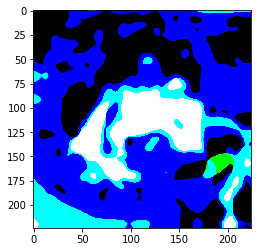

In [0]:
from eval_ckpt_main import MEAN_RGB, STDDEV_RGB

class EfficientNetPreprocessLayer(tf.keras.layers.Layer):
    def __init__(self, image_size, dtype=tf.float32, **kwargs):
        super(EfficientNetPreprocessLayer, self).__init__(**kwargs)
        self.image_size = image_size
        self.output_dtype = dtype
        self.mean_rgb = tf.constant(MEAN_RGB, shape=[1, 1, 3], dtype=dtype)
        self.stddev_rgb = tf.constant(STDDEV_RGB, shape=[1, 1, 3], dtype=dtype)
        
    def preprocess(self, img):
        img = preprocess_image(tf.io.encode_jpeg(img), image_size=self.image_size)
        img = tf.subtract(img, self.mean_rgb)
        img = tf.divide(img, self.stddev_rgb)
        return img
        
    def call(self, inputs, training=None):
        return tf.map_fn(self.preprocess, inputs, self.output_dtype)
    
class ResNetPreprocessLayer(tf.keras.layers.Layer):
    def __init__(self, image_size, dtype=tf.float32, **kwargs):
        super(ResNetPreprocessLayer, self).__init__(**kwargs)
        self.image_size = image_size
        
    def call(self, inputs, training=None):
        x = tf.image.resize_bicubic(inputs, size=(self.image_size, self.image_size))
        x = tf.keras.applications.resnet50.preprocess_input(x)
        return x
    
preprocess_layer = {
    "efficientnet": EfficientNetPreprocessLayer,
    "resnet": ResNetPreprocessLayer,
}[BASE_MODEL_TYPE]
    
# test
with tf.Session() as sess:
    a = sess.run(preprocess_layer(IMAGE_SIZE)(tf.constant(x_trn[:10])))
    from matplotlib import pyplot as plt
    plt.imshow(a[0])
    plt.show()

In [0]:
def get_features_model(base, x, image_size, preprocess_layer):
    inp = tf.keras.layers.Input(shape=x.shape[1:])
    x = preprocess_layer(image_size)(inp)
    x = base(x)
    return tf.keras.Model(inp, x)

features_model = get_features_model(base, x_trn, IMAGE_SIZE, preprocess_layer)
features_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
res_net_preprocess_layer_23  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
x_features_trn = features_model.predict(x_trn, batch_size=128, verbose=True)
x_features_val = features_model.predict(x_val, batch_size=128, verbose=True)

10000/10000 [==============================] - 34s 3ms/sample


In [0]:
from sklearn import linear_model, metrics
clf = linear_model.RidgeClassifier()
clf.fit(x_features_trn, y_trn.squeeze())
print(metrics.accuracy_score(y_val, clf.predict(x_features_val)))
# EfficientNetB0 (4mil params): 0.8747
# ResNet50 (23mil params): 0.9168

0.9168
